# Working with filing data from the SEC's EDGAR service


In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

from pathlib import Path
from datetime import date
import json
from io import BytesIO
from zipfile import ZipFile, BadZipFile
from tqdm import tqdm
import requests

import yfinance as yf
import pandas as pd

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [3]:
sns.set_style("whitegrid")

In [4]:
# store data in this directory since we won't use it in other chapters
data_path = Path(
    "../../data/edgar_xbrl"
)  # perhaps set to external harddrive to accomodate large amount of data
if not data_path.exists():
    data_path.mkdir()

## Download FS & Notes Data


The following code downloads and extracts all historical filings contained in the [Financial Statement and Notes](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html) (FSN) datasets from Q1/2014 through Q3/2020.

> The SEC has moved to a monthly cadence after Q3/2020; feel free to extend the code by creating the correpsonding file names (see linked website) and download those as well.


**Downloads over 40GB of data!**


In [32]:
SEC_URL = "https://www.sec.gov/"
FSN_PATH = "files/dera/data/financial-statement-notes-data-sets/"

In [33]:
filing_periods = [
    (d.year, d.quarter) for d in pd.date_range("2014", "2020-09-30", freq="Q")
]
filing_periods

[(2014, 1),
 (2014, 2),
 (2014, 3),
 (2014, 4),
 (2015, 1),
 (2015, 2),
 (2015, 3),
 (2015, 4),
 (2016, 1),
 (2016, 2),
 (2016, 3),
 (2016, 4),
 (2017, 1),
 (2017, 2),
 (2017, 3),
 (2017, 4),
 (2018, 1),
 (2018, 2),
 (2018, 3),
 (2018, 4),
 (2019, 1),
 (2019, 2),
 (2019, 3),
 (2019, 4),
 (2020, 1),
 (2020, 2),
 (2020, 3)]

In [34]:
with requests.Session() as session:
    session.proxies = {
        "http": "http://127.0.0.1:7890/",
        "https": "https://127.0.0.1:7890/",
    }
    session.headers = {
        "User-Agent": "xxxx@finort.com",
        "Accept-Encoding": "gzip, deflate",
    }
    for yr, qtr in tqdm(filing_periods):
        # set (and create) directory
        path = data_path / f"{yr}_{qtr}" / "source"
        if not path.exists():
            path.mkdir(parents=True)

        # define url and get file
        filing = f"{yr}q{qtr}_notes.zip"
        url = SEC_URL + FSN_PATH + filing
        response = session.get(url).content

        # decompress and save
        try:
            with ZipFile(BytesIO(response)) as zip_file:
                for file in zip_file.namelist():
                    local_file = path / file
                    if local_file.exists():
                        continue
                    with local_file.open("wb") as output:
                        for line in zip_file.open(file).readlines():
                            output.write(line)
        except BadZipFile:
            print(f"\nBad zip file: {yr} {qtr}\n")
            continue

100%|██████████| 27/27 [20:46<00:00, 46.18s/it]


## Save to parquet


The data is fairly large and to enable faster access than the original text files permit, it is better to convert the text files to binary, columnar parquet format (see Section 'Efficient data storage with pandas' in chapter 2 for a performance comparison of various data-storage options compatible with pandas DataFrames):


> Some fo the `txt.tsv` source files contain a small number of faulty lines; the code below drops those lines but indicates the line numbers where you can find the errors if you would like to investigate further.


In [36]:
for f in tqdm(sorted(list(data_path.glob("**/*.tsv")))):
    # set (and create) directory
    parquet_path = f.parent.parent / "parquet"
    if not parquet_path.exists():
        parquet_path.mkdir(parents=True)

    # write content to .parquet
    file_name = f.stem + ".parquet"
    if not (parquet_path / file_name).exists():
        try:
            df = pd.read_csv(
                f, sep="\t", encoding="latin1", low_memory=False, on_bad_lines="skip"
            )
            df.to_parquet(parquet_path / file_name)
        except Exception as e:
            print(e, " | ", f)
        # optional: uncomment to delete original .tsv
#         else:
# f.unlink

100%|██████████| 216/216 [10:51<00:00,  3.02s/it]


## Metadata json


In [5]:
file = data_path / "2018_3" / "source" / "2018q3_notes-metadata.json"
with file.open() as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

## Data Organization


For each quarter, the FSN data is organized into eight file sets that contain information about submissions, numbers, taxonomy tags, presentation, and more. Each dataset consists of rows and fields and is provided as a tab-delimited text file:


| File | Dataset      | Description                                                 |
| ---- | ------------ | ----------------------------------------------------------- |
| SUB  | Submission   | Identifies each XBRL submission by company, form, date, etc |
| TAG  | Tag          | Defines and explains each taxonomy tag                      |
| DIM  | Dimension    | Adds detail to numeric and plain text data                  |
| NUM  | Numeric      | One row for each distinct data point in filing              |
| TXT  | Plain Text   | Contains all non-numeric XBRL fields                        |
| REN  | Rendering    | Information for rendering on SEC website                    |
| PRE  | Presentation | Detail on tag and number presentation in primary statements |
| CAL  | Calculation  | Shows arithmetic relationships among tags                   |


## Submission Data


The latest submission file contains around 6,500 entries.


In [6]:
sub = pd.read_parquet(data_path / "2018_3" / "parquet" / "sub.parquet")
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         6493 non-null   object 
 1   cik          6493 non-null   int64  
 2   name         6493 non-null   object 
 3   sic          6492 non-null   float64
 4   countryba    6482 non-null   object 
 5   stprba       5900 non-null   object 
 6   cityba       6482 non-null   object 
 7   zipba        6478 non-null   object 
 8   bas1         6482 non-null   object 
 9   bas2         2804 non-null   object 
 10  baph         6482 non-null   object 
 11  countryma    6448 non-null   object 
 12  stprma       5906 non-null   object 
 13  cityma       6448 non-null   object 
 14  zipma        6447 non-null   object 
 15  mas1         6448 non-null   object 
 16  mas2         2761 non-null   object 
 17  countryinc   5936 non-null   object 
 18  stprinc      5632 non-null   object 
 19  ein   

### Get AAPL submission


The submission dataset contains the unique identifiers required to retrieve the filings: the Central Index Key (CIK) and the Accession Number (adsh). The following shows some of the information about Apple's 2018Q1 10-Q filing:


In [7]:
name = "APPLE INC"
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = [
    "name",
    "adsh",
    "cik",
    "name",
    "sic",
    "countryba",
    "stprba",
    "cityba",
    "zipba",
    "bas1",
    "form",
    "period",
    "fy",
    "fp",
    "filed",
]
apple.loc[key_cols]

name                    APPLE INC
adsh         0000320193-18-000100
cik                        320193
name                    APPLE INC
sic                        3571.0
countryba                      US
stprba                         CA
cityba                  CUPERTINO
zipba                       95014
bas1           ONE APPLE PARK WAY
form                         10-Q
period                   20180630
fy                         2018.0
fp                             Q3
filed                    20180801
Name: 1101, dtype: object

## Build AAPL fundamentals dataset


Using the central index key, we can identify all historical quarterly filings available for Apple, and combine this information to obtain 26 Forms 10-Q and nine annual Forms 10-K.


### Get filings


In [8]:
aapl_subs = pd.DataFrame()
for sub in data_path.glob("**/sub.parquet"):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[
        (sub.cik.astype(int) == apple.cik) & (sub.form.isin(["10-Q", "10-K"]))
    ]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

We find 15 quarterly 10-Q and 4 annual 10-K reports:


In [9]:
aapl_subs.form.value_counts()

form
10-Q    21
10-K     6
Name: count, dtype: int64

### Get numerical filing data


With the Accession Number for each filing, we can now rely on the taxonomies to select the appropriate XBRL tags (listed in the TAG file) from the NUM and TXT files to obtain the numerical or textual/footnote data points of interest.


First, let's extract all numerical data available from the 19 Apple filings:


In [10]:
aapl_nums = pd.DataFrame()
for num in data_path.glob("**/num.parquet"):
    num = pd.read_parquet(num).drop("dimh", axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format="%Y%m%d")
aapl_nums.to_parquet(data_path / "aapl_nums.parquet")

682
805
919
1271
751
942
961
1345
707
905
923
1277
738
951
1001
1364
793
952
937
1224
755
1035
1039
1176
784
1017
1028


In total, the nine years of filing history provide us with over 18,000 numerical values for AAPL.


In [11]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26282 entries, 3544439 to 3339747
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   adsh      26282 non-null  object        
 1   tag       26282 non-null  object        
 2   version   26282 non-null  object        
 3   ddate     26282 non-null  datetime64[ns]
 4   qtrs      26282 non-null  int64         
 5   uom       26282 non-null  object        
 6   iprx      26282 non-null  int64         
 7   value     26218 non-null  float64       
 8   footnote  68 non-null     object        
 9   footlen   26282 non-null  int64         
 10  dimn      26282 non-null  int64         
 11  coreg     0 non-null      object        
 12  durp      26282 non-null  float64       
 13  datp      26282 non-null  float64       
 14  dcml      26282 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
memory usage: 3.2+ MB


## Create P/E Ratio from EPS and stock price data


We can select a useful field, such as Earnings per Diluted Share (EPS), that we can combine with market data to calculate the popular Price/Earnings (P/E) valuation ratio.


In [12]:
stock_split = 7
split_date = pd.to_datetime("20140604")
split_date

Timestamp('2014-06-04 00:00:00')

We do need to take into account, however, that Apple split its stock 7:1 on June 4, 2014, and Adjusted Earnings per Share before the split to make earnings comparable, as illustrated in the following code block:


In [13]:
# Filter by tag; keep only values measuring 1 quarter
eps = aapl_nums[
    (aapl_nums.tag == "EarningsPerShareDiluted") & (aapl_nums.qtrs == 1)
].drop("tag", axis=1)

# Keep only most recent data point from each filing
eps = eps.groupby("adsh").apply(lambda x: x.nlargest(n=1, columns=["ddate"]))

# Adjust earnings prior to stock split downward
eps.loc[eps.ddate < split_date, "value"] = eps.loc[eps.ddate < split_date, "value"].div(
    7
)
eps = eps[["ddate", "value"]].set_index("ddate").squeeze().sort_index()
eps = eps.rolling(4, min_periods=4).sum().dropna()

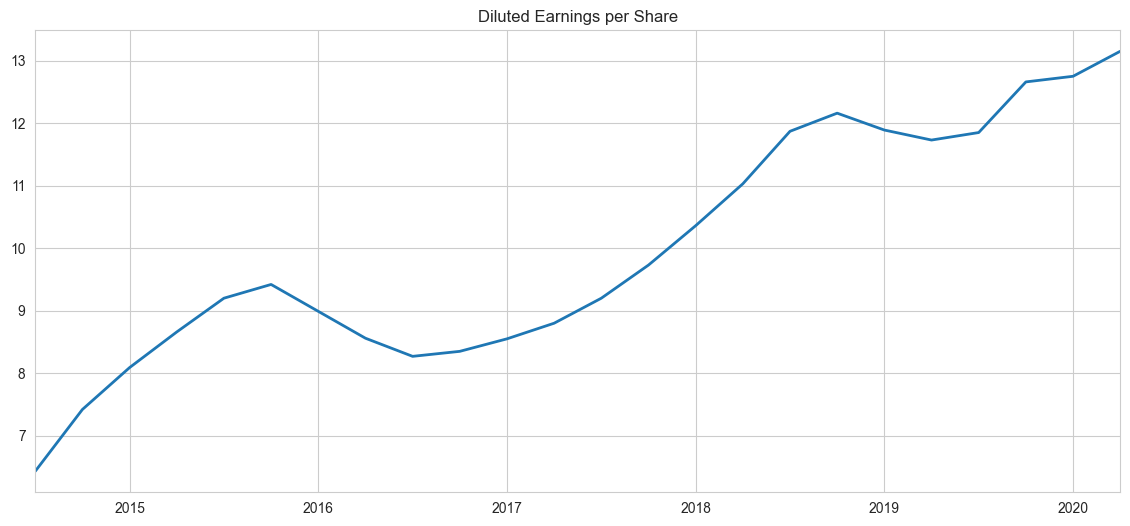

In [14]:
eps.plot(lw=2, figsize=(14, 6), title="Diluted Earnings per Share")
plt.xlabel("")
# plt.savefig("diluted eps", dps=300)
plt.show()

In [54]:
symbol = "AAPL.US"

aapl_stock = (
    yf.Ticker("AAPL")
    .history(start=eps.index.min(), end=eps.index.max())
    .resample("D")
    .last()
)
aapl_stock.index = pd.to_datetime(aapl_stock.index.strftime("%Y-%m-%d"))
aapl_stock = aapl_stock.loc["2014" : eps.index.max()]
aapl_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2100 entries, 2014-09-30 to 2020-06-29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1447 non-null   float64
 1   High          1447 non-null   float64
 2   Low           1447 non-null   float64
 3   Close         1447 non-null   float64
 4   Volume        1447 non-null   float64
 5   Dividends     1447 non-null   float64
 6   Stock Splits  1447 non-null   float64
dtypes: float64(7)
memory usage: 131.2 KB


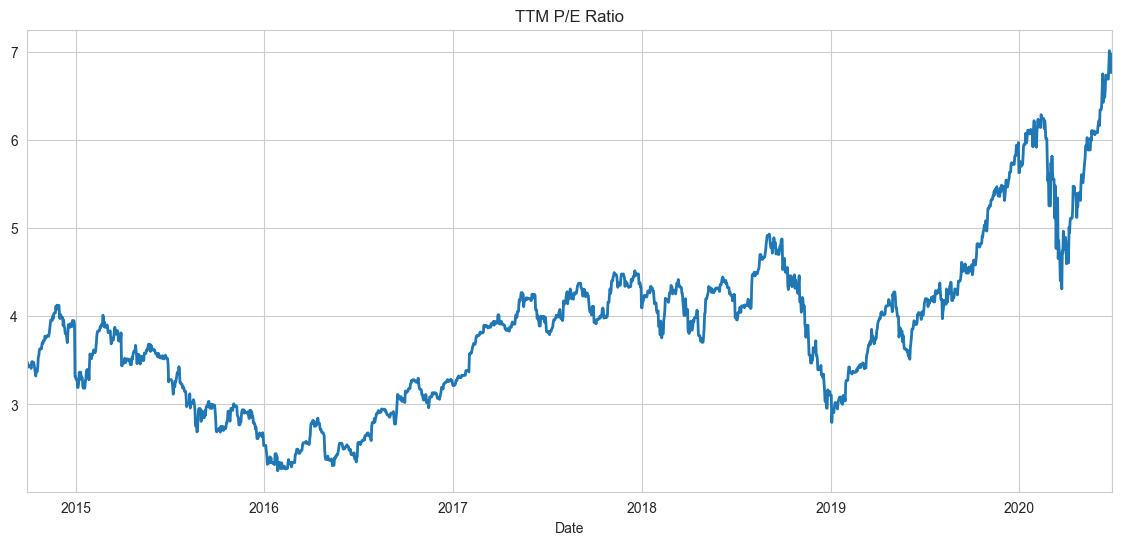

In [55]:
pe = aapl_stock.Close.to_frame("price").join(eps.to_frame("eps"))
pe = pe.fillna(method="ffill").dropna()
pe["P/E Ratio"] = pe.price.div(pe.eps)
pe["P/E Ratio"].plot(lw=2, figsize=(14, 6), title="TTM P/E Ratio")
plt.show()

In [56]:
pe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2100 entries, 2014-09-30 to 2020-06-29
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      2100 non-null   float64
 1   eps        2100 non-null   float64
 2   P/E Ratio  2100 non-null   float64
dtypes: float64(3)
memory usage: 65.6 KB


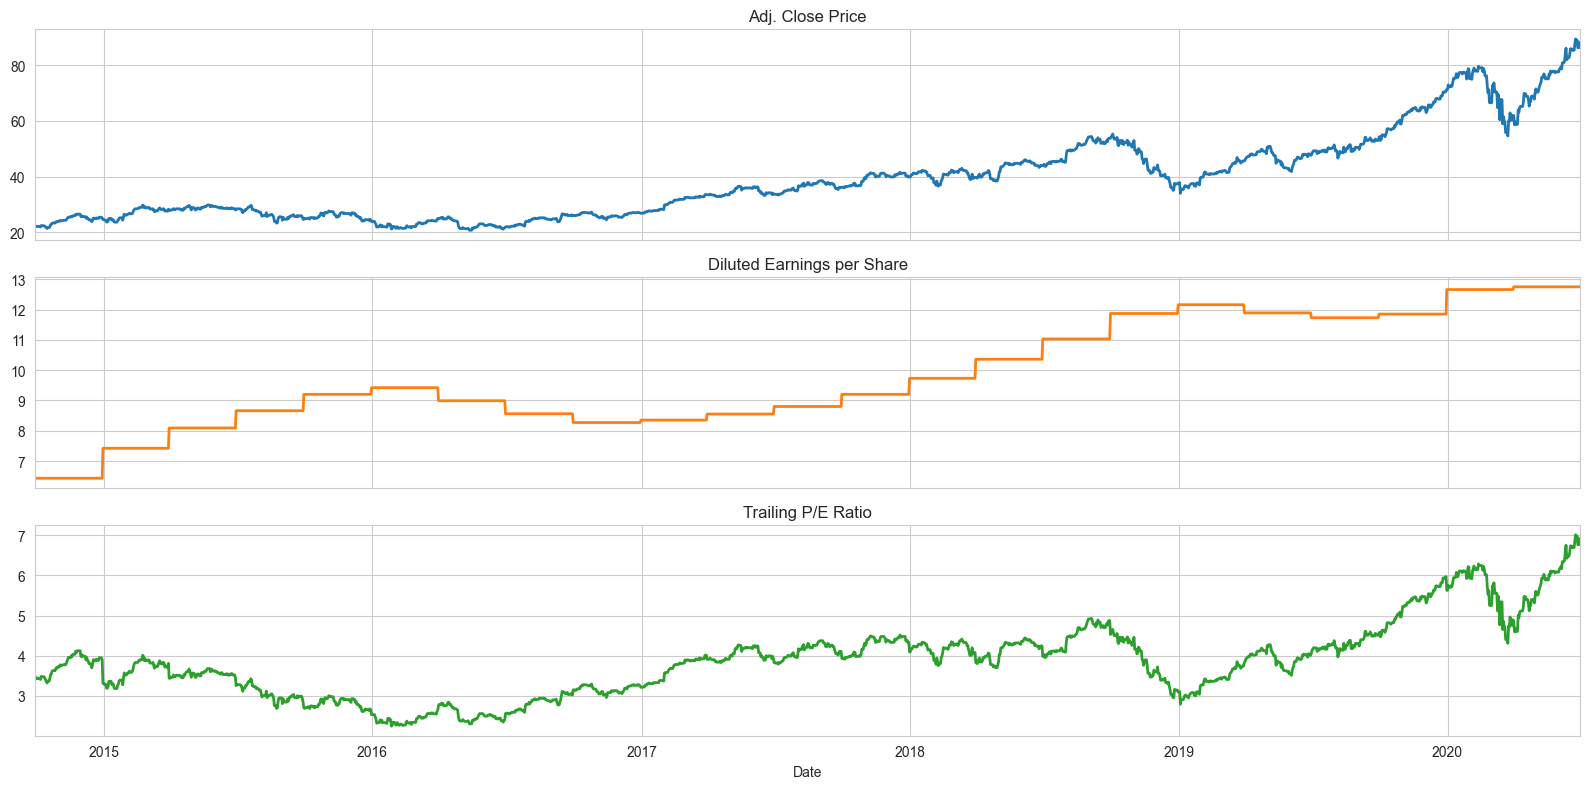

In [57]:
axes = pe.plot(subplots=True, figsize=(16, 8), legend=False, lw=2)
axes[0].set_title("Adj. Close Price")
axes[1].set_title("Diluted Earnings per Share")
axes[2].set_title("Trailing P/E Ratio")
plt.tight_layout()
plt.show()

## Explore Additional Fields


The field `tag` references values defined in the taxonomy:


In [58]:
aapl_nums.tag.value_counts()

tag
CashAndCashEquivalentsAtCarryingValue                                                                             810
DebtInstrumentInterestRateEffectivePercentage                                                                     782
OperatingIncomeLoss                                                                                               650
AvailableForSaleSecuritiesNoncurrent                                                                              560
AvailableForSaleSecuritiesCurrent                                                                                 560
                                                                                                                 ... 
ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsExercisableWeightedAverageExercisePrice             1
PreferredStockSharesAuthorized                                                                                      1
ShareBasedCompensationArrangementByShareBasedPayment

We can select values of interest and track their value or use them as inputs to compute fundamental metrics like the Dividend/Share ratio.


### Dividends per Share


In [59]:
fields = [
    "EarningsPerShareDiluted",
    "PaymentsOfDividendsCommonStock",
    "WeightedAverageNumberOfDilutedSharesOutstanding",
    "OperatingIncomeLoss",
    "NetIncomeLoss",
    "GrossProfit",
]

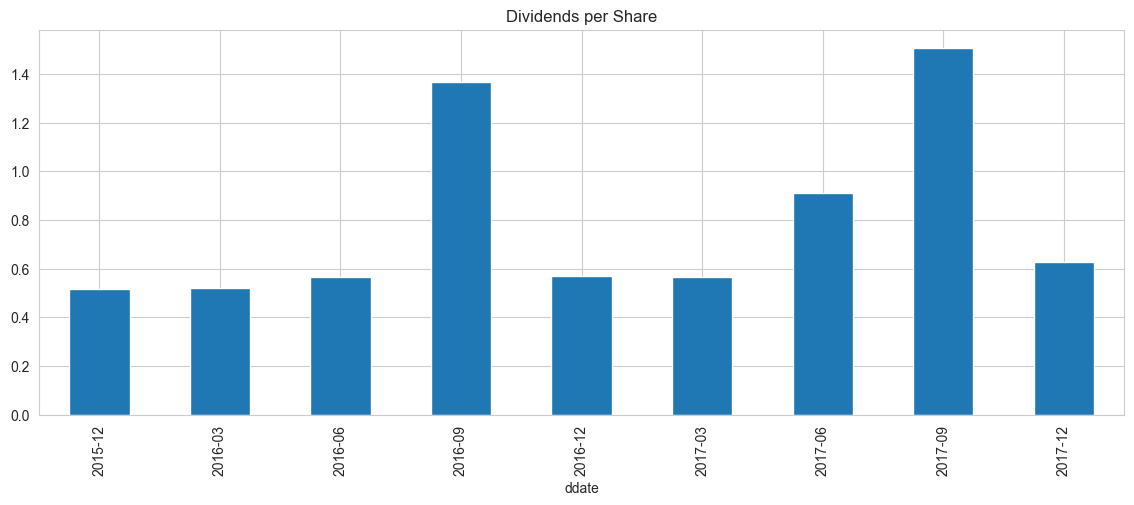

In [62]:
dividends = (
    aapl_nums.loc[aapl_nums.tag == "PaymentsOfDividendsCommonStock", ["ddate", "value"]]
    .groupby("ddate")
    .mean()
)
shares = (
    aapl_nums.loc[
        aapl_nums.tag == "WeightedAverageNumberOfDilutedSharesOutstanding",
        ["ddate", "value"],
    ]
    .drop_duplicates()
    .groupby("ddate")
    .mean()
)
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title="Dividends per Share", legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime("%Y-%m")))
plt.show()

## Bonus: Textual Information


In [63]:
txt = pd.read_parquet(data_path / "2016_2" / "parquet" / "txt.parquet")

AAPL's adsh is not avaialble in the txt file but you can obtain notes from the financial statements here:


In [64]:
txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
0,0000799288-16-000122,AmendmentFlag,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,5,5,None,0,FD2015Q4YTD,false
1,0000799288-16-000122,CurrentFiscalYearEndDate,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,7,7,None,0,FD2015Q4YTD,--01-29
2,0000799288-16-000122,DocumentFiscalPeriodFocus,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,2,2,None,0,FD2015Q4YTD,FY
3,0000799288-16-000122,DocumentFiscalYearFocus,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,4,4,None,0,FD2015Q4YTD,2015
4,0000799288-16-000122,DocumentPeriodEndDate,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,10,10,None,0,FD2015Q4YTD,2016-01-29
